┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (1000×21×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.26 seconds
Compute duration  = 4.26 seconds
parameters        = p_class1, λ1_class1, λ1_class2, p2_class1, p2_class2, k3_class1, θ3_class1, k3_class2, θ3_class2
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

    p_class1    0.5007    0.2929    0.0075   1205.6572   468.2837    1.0005    ⋯
   λ1_class1    1.7406    0.0720    0.0017   1829.5246   742.6619    1.0006    ⋯
   λ1_class2    2.2427    0.1160    0.0038    927.2073   653.8178    1.0067    ⋯
   p2_class1    0.4071    0.0199    0.0006   1138.7460   76

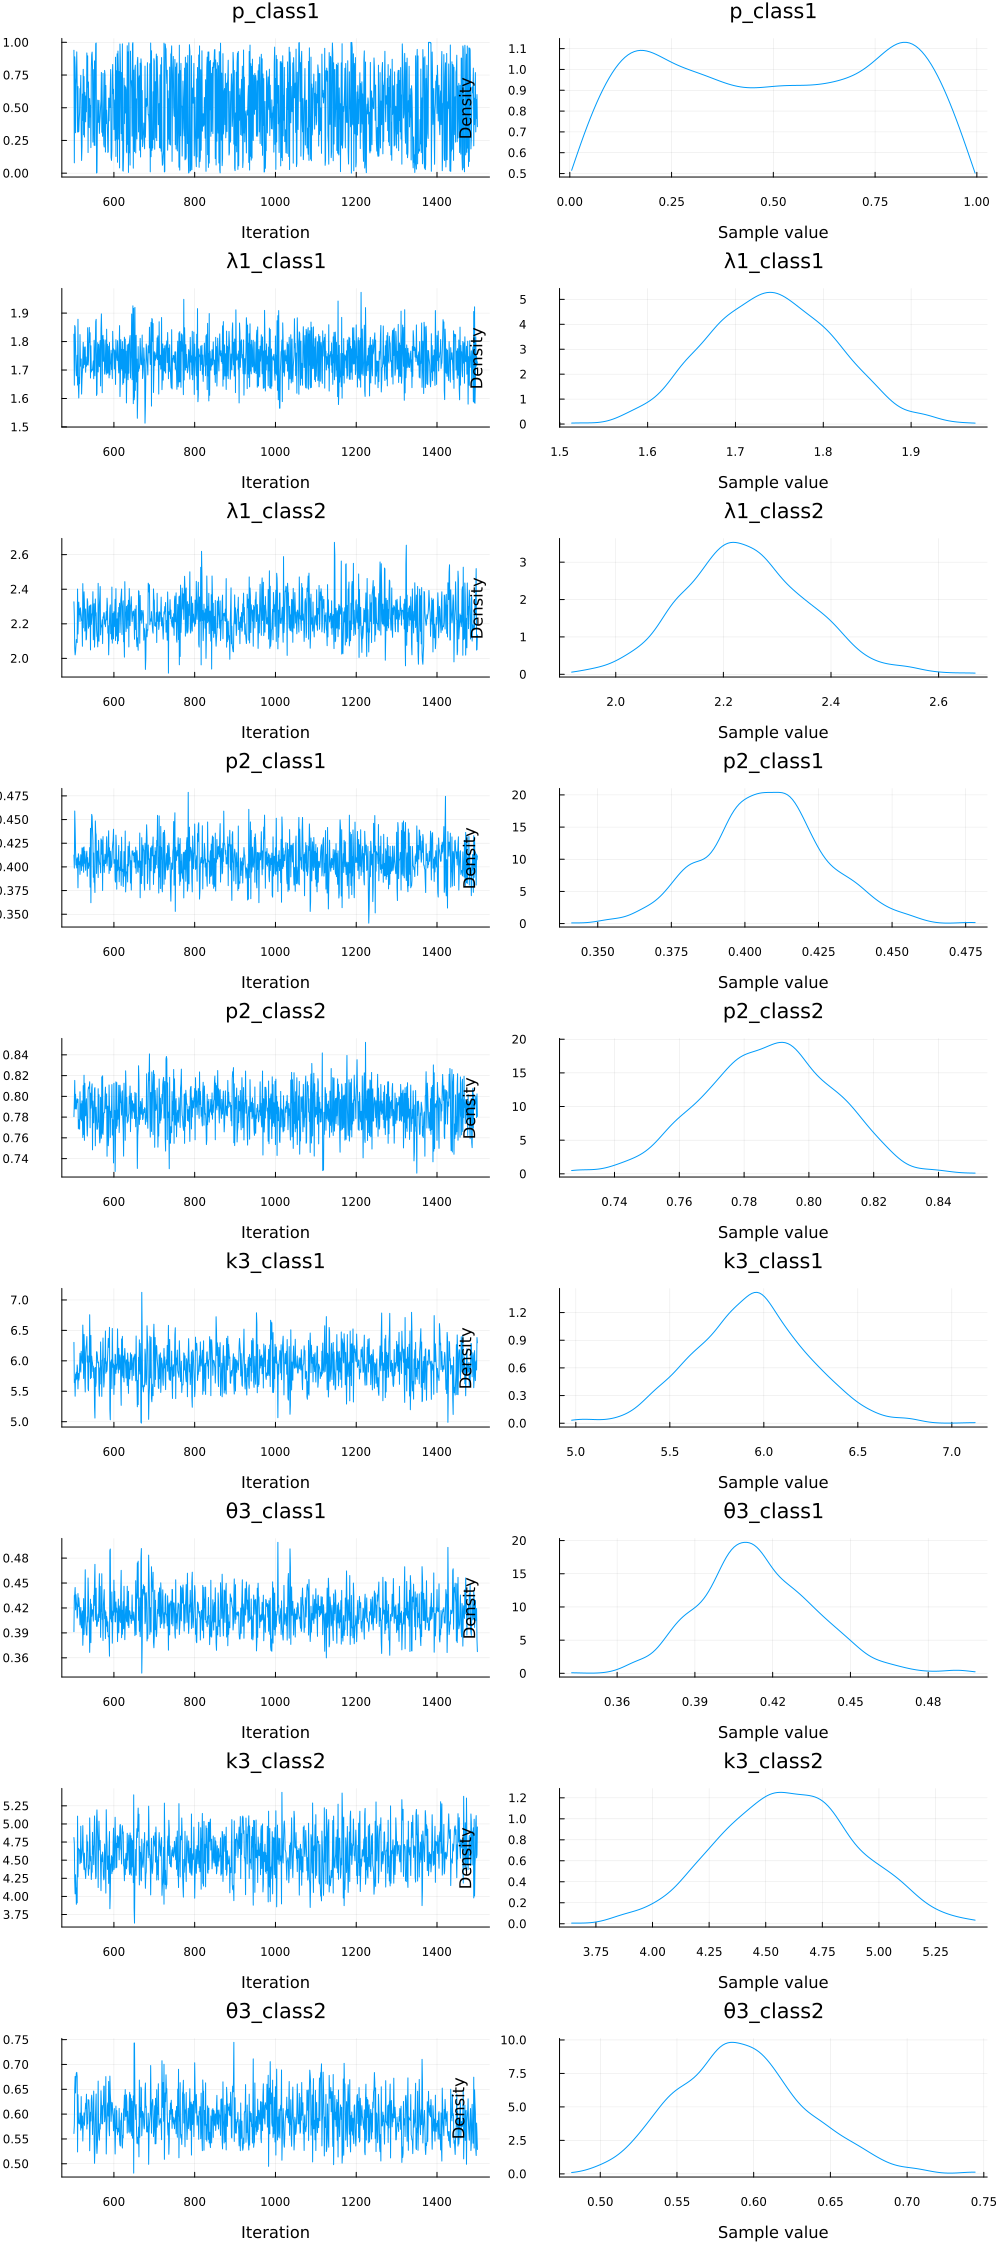

Probability of being class 1: 0.42658015170164754


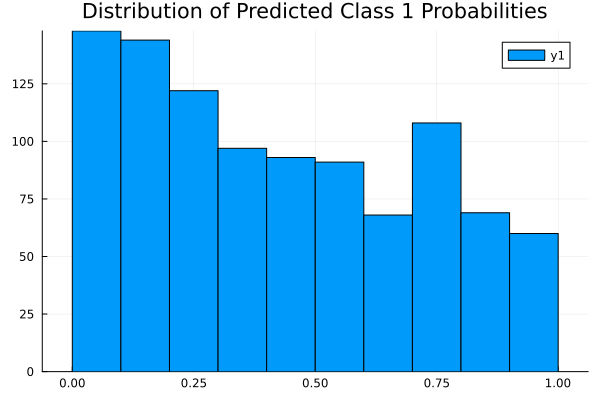

"/home/tau/repository/Mymljl/src/class_probs_hist.png"

In [4]:
using Turing
using Distributions
using DataFrames
using Random
using Plots
using StatsPlots

# Set seed for reproducibility
Random.seed!(123)

# Generate sample data with mixed distributions (same as before)
n_samples = 1000
feature1 = rand(Exponential(2), n_samples)
feature2 = rand([0, 1], n_samples)
feature3 = rand(Gamma(5, 0.5), n_samples)

p_class1 = 0.6
p_class2 = 1 - p_class1

labels = zeros(Int, n_samples)
for i in 1:n_samples
    prob_class1 = p_class1 * pdf(Exponential(2), feature1[i]) * pdf(Bernoulli(0.3), feature2[i]) * pdf(Gamma(5, 0.5), feature3[i])
    prob_class2 = p_class2 * pdf(Exponential(3), feature1[i]) * pdf(Bernoulli(0.7), feature2[i]) * pdf(Gamma(3, 1), feature3[i])

    prob_class1_norm = prob_class1 / (prob_class1 + prob_class2)
    labels[i] = rand() < prob_class1_norm ? 1 : 2
end

df = DataFrame(Feature1 = feature1, Feature2 = feature2, Feature3 = feature3, Label = labels)

# Turing model for Naive Bayes with mixed distributions (CORRECTED)
@model function naive_bayes_mixed(feature1, feature2, feature3, labels)
    # Priors for class probabilities
    p_class1 ~ Beta(1, 1)
    p_class2 = 1 - p_class1

    # Priors for distribution parameters (one set per class)
    λ1_class1 ~ truncated(Normal(2, 1), lower = 0) # Use the true values as a starting point for the priors
    λ1_class2 ~ truncated(Normal(3, 1), lower = 0)
    p2_class1 ~ Beta(0.3, 1) # Use the true values as a starting point for the priors
    p2_class2 ~ Beta(0.7, 1)
    k3_class1 ~ truncated(Normal(5, 1), lower = 0)
    θ3_class1 ~ truncated(Normal(0.5, 0.5), lower = 0)
    k3_class2 ~ truncated(Normal(3, 1), lower = 0)
    θ3_class2 ~ truncated(Normal(1, 0.5), lower = 0)

    # Likelihood (Vectorized)
    for i in 1:length(labels)
        if labels[i] == 1
            feature1[i] ~ Exponential(λ1_class1)
            feature2[i] ~ Bernoulli(p2_class1)
            feature3[i] ~ Gamma(k3_class1, θ3_class1)
        else
            feature1[i] ~ Exponential(λ1_class2)
            feature2[i] ~ Bernoulli(p2_class2)
            feature3[i] ~ Gamma(k3_class2, θ3_class2)
        end
    end

    return p_class1, λ1_class1, λ1_class2, p2_class1, p2_class2, k3_class1, θ3_class1, k3_class2, θ3_class2
end

# Create and sample the model
model = naive_bayes_mixed(df.Feature1, df.Feature2, df.Feature3, df.Label)
chain = sample(model, NUTS(0.65), 1000)

display(chain)
display(plot(chain))
savefig("chains.png")

# Prediction (Corrected)
function predict_label_probability(chain, new_feature1, new_feature2, new_feature3)
    n_samples = length(chain)
    prob_class1 = zeros(n_samples)
    for i in 1:n_samples
        λ1_class1_i = chain[:λ1_class1][i]
        p2_class1_i = chain[:p2_class1][i]
        k3_class1_i = chain[:k3_class1][i]
        θ3_class1_i = chain[:θ3_class1][i]
        λ1_class2_i = chain[:λ1_class2][i]
        p2_class2_i = chain[:p2_class2][i]
        k3_class2_i = chain[:k3_class2][i]
        θ3_class2_i = chain[:θ3_class2][i]
        p_class1_i = chain[:p_class1][i]
        p_class2_i = 1 - p_class1_i

        prob_class1_unnorm = p_class1_i * pdf(Exponential(λ1_class1_i), new_feature1) * pdf(Bernoulli(p2_class1_i), new_feature2) * pdf(Gamma(k3_class1_i, θ3_class1_i), new_feature3)
        prob_class2_unnorm = p_class2_i * pdf(Exponential(λ1_class2_i), new_feature1) * pdf(Bernoulli(p2_class2_i), new_feature2) * pdf(Gamma(k3_class2_i, θ3_class2_i), new_feature3)
        prob_class1[i] = prob_class1_unnorm / (prob_class1_unnorm + prob_class2_unnorm)
    end
    return prob_class1
end

new_feature1 = 1.5
new_feature2 = 1
new_feature3 = 2.5
prob_class1_new = predict_label_probability(chain, new_feature1, new_feature2, new_feature3)
println("Probability of being class 1: ", mean(prob_class1_new))
display(histogram(prob_class1_new, title="Distribution of Predicted Class 1 Probabilities"))
savefig("class_probs_hist.png")